In [32]:
import torch
import torch.nn as nn
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt

## Automatic differentiation (Autograd)

Autograd is the Pytorch engine that performs gradient tracking and computation. It really is the core of neural networks training, since optimization algorithms like stochastic gradient descent rely on gradient computation. Every tensor in Pytorch not only contains some values (the data itself), but also stores the gradients related to operations that have been computed using these tensors.

In [33]:
# By default, when tensors are created their gradients is not tracked
x = torch.ones(1, 10)
print(x.requires_grad)

False


In [34]:
# You can change it using the requires_grad_() method
x.requires_grad_()
print(x.requires_grad)

# Alternatively, when creating a tensor, you can directly set 'requires_grad=True'
x = torch.ones(1, 10, requires_grad=True)
print(x.requires_grad)

True
True


In [35]:
# You can access the gradient stored in x with 'x.grad'.
# However, since no computation has been performed yet, it should return 'None'
print(x.grad)

None


In [36]:
# If you create a tensor y from x using any torch operation, it will have a gradient function (grad_fn) which is specific to this operation
y = x + 50
print(y.grad_fn)

y = 3 * x
print(y.grad_fn)

y = x.mean()
print(y.grad_fn)

As an example, let's define an operation involving a 1D data tensor $\mathbf{x} = [x_0, \ldots, x_{9}]$ and a parameter $a$:

$$ loss = a \times \sum_i x_i $$

We can mathematically compute the gradient of $loss$ with respect to $a$ and $\mathbf{x}$:

$$ \nabla_{a} loss = \sum_i x_i $$
and
$$  \nabla_{x_i} loss = a \quad (\text{or in vector form:} \quad \nabla_{\mathbf{x}} loss = [a, \ldots, a]) $$

Of course, on this example it's easy to compute gradients by hand. But when working with deep neural networks with millions of parameters, it can be a bit more complicated. The good news is that Pytorch does it automatically for us, thanks to the `backward()` method.

In [37]:
# Let's implement the above:
a = torch.tensor([3.], requires_grad=True)
x = torch.ones(1, 10, requires_grad=True)
loss = x.sum() * a

print(loss.requires_grad)
print(loss.grad_fn)

True


In [38]:
a

tensor([3.], requires_grad=True)

In [39]:
x

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)

In [40]:
loss

tensor([30.], grad_fn=<MulBackward0>)

In [41]:
# Now, let's compute the gradient of the loss with respect to x and a
loss.backward()

# These gradients are stored in x.grad and a.grad
print(x.grad)
print(a.grad)

tensor([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])
tensor([10.])


As you can see, `x.grad` and `a.grad` contain $\nabla_{\mathbf{x}} loss$ and $\nabla_a loss$, respectively.

**Note**: In this example, we have computed the gradient with respect to both the input data $\mathbf{x}$ and the parameter $a$, but this is only for illustrative purpose. Indeed, in practice, we do not compute the gradient with respect to the data ($\mathbf{x}$) because it is fixed; we are only interested in the gradient with respect to the parameter ($a$), since this is what we optimize using gradient descent.

In [42]:
# After a model is trained, we no longer need to compute its gradient. Therefore, when doing prediction,
# we can disable gradient tracking to save memory and computational time

with torch.no_grad():
    loss = x.sum() * a
    print(loss.requires_grad)

False


In [43]:
# TO DO:
# - define a data tensors x which simply contains the value 2
x = torch.tensor([2])
# - define another data tensor y which simply contains the value 10
y = torch.tensor([10])
# - define parameter tensors w and b with values 1 and 3, respectively (these need gradient tracking)
w = torch.ones(1,1, requires_grad=True)
b = torch.tensor([3.], requires_grad=True)
# - compute the loss as: loss=(y - (w*x + b))^2
loss = (y-(w*x+b))**2
# - compute the gradients of loss
loss.backward()
# - print the value of the gradient of loss with respect to w and b
print(w.grad)
print(b.grad)
# hint: to be sure there's no mistake, you can check if it's correct with a bit of math.

tensor([[-20.]])
tensor([-10.])


<span style="color:red">**Q1**</span> Put the values of these gradients in your report.

## Linear regression

<center><a href="https://kpu.pressbooks.pub/learningstatistics/chapter/linear-regression/">
    <img src="https://kpu.pressbooks.pub/app/uploads/sites/66/2019/09/regression1a-1.png" width="500"></a></center>

Let's now address linear regression. Assuming we have several points of data pairs $(x,y)$, the model is simply $f(x) = wx + b$, where $w$ is called *weight* (or slope) and $b$ is called the *bias*. The goal of linear regression is to estimate the optimal $w$ and $b$ from the available training data $x$ and $y$.

**Note**: we don't really need Pytorch for solving that problem (indeed, a basic gradient descent algorithm can be implemented directly without too much hassle - if you have some math background and want to have fun, please feel free). Nonetheless, we consider it anyway because it's a good basic exercice, and once linear regression is solved, we can move to more sophisticated nonlinear regression and to (deep) neural networks.

### Data

torch.Size([15, 1]) torch.Size([15, 1])


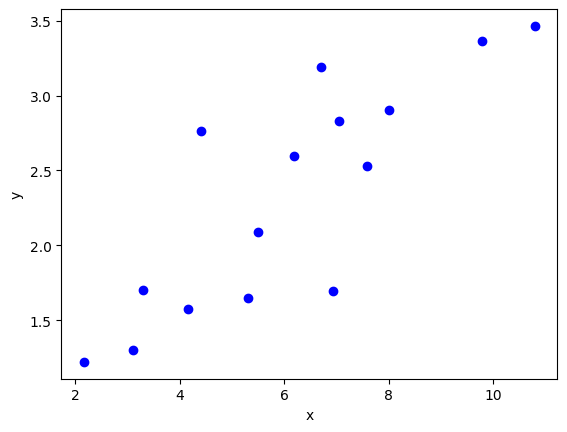

In [44]:
# Create a toy dataset (we store all values of x and y into single tensors 'all_x' and 'all_y')
all_x = torch.tensor([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168], [9.779], [6.182], [7.59],
                 [2.167], [7.042], [10.791], [5.313], [7.997], [3.1]], dtype=torch.float)
all_y = torch.tensor([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573], [3.366], [2.596], [2.53],
                 [1.221], [2.827], [3.465], [1.65], [2.904], [1.3]], dtype=torch.float)
print(all_x.shape, all_y.shape)

# Plot the data (y as a function of x)
plt.figure()
plt.plot(all_x, all_y, 'bo')
plt.xlabel('x'), plt.ylabel('y')
plt.show()

The data tensors `all_x` and `all_y` we have defined here constitute our *dataset*, which has therefore a length of 15; and each data sample $(x,y)$ is one element in `(all_x,all_y)`. Since it's a very small and simple dataset, we don't need to use a Pytorch `Dataset` or `Dataloader` object as introduced in lab 1; we can directly consider that our dataset consists of 1 batch of data, with a batch size of 15.

### Model

Let us create our linear model. In pytorch, it's easily done with `nn.Linear` (check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=torch%20nn%20linear#torch.nn.Linear)!). In particular, we need to specify the input and output sizes. In our case, these are equal to 1 since we work with scalars. There is also an option `bias` which can be `True` (default) or `False`. If `bias=False`, then $b=0$ and the model reduces to $f(x) = wx$.

**Note**: When we create a Pytorch model using any `torch.nn` module, the corresponding parameters have `requires_grad=True` by default, thus you don't need to explicitly specify it.

In [45]:
# Create the linear model
input_size = 1
output_size = 1
lin_reg_model = nn.Linear(input_size, output_size, bias=True)

# 'lin_reg_model' is a module which contains the linear function and its parameters (weight and bias)
# When we instanciate the model, the parameters are initialized with random values
# We also remark that both parameters have 'requires_grad=True', which is the normal default behavior.
print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[-0.0198]], requires_grad=True)
Parameter containing:
tensor([0.7929], requires_grad=True)


In [46]:
# Now we can easily compute predictions as y_pred = f(x) as follows:
x = all_x[0]
y_pred = lin_reg_model(x)
print(y_pred)

# Since y_pred is computed from the model (which has requires_grad=True), it also has requires_grad=True
print(y_pred.requires_grad)

tensor([0.7275], grad_fn=<AddBackward0>)
True


False


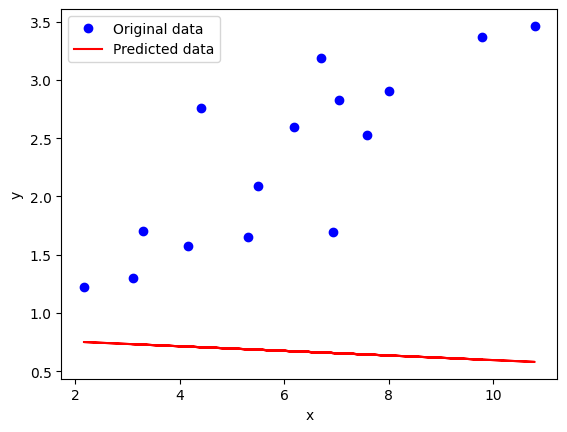

In [47]:
# Let's compute predictions for all the data at once:
all_y_pred = lin_reg_model(all_x)

# If we want to plot all_y_pred, we first need to get rid of the tracked gradient. This is done as follows:
all_y_pred = all_y_pred.detach()
print(all_y_pred.requires_grad)

# We can plot the predicted values on top of the original data
plt.figure()
plt.plot(all_x, all_y, 'bo', label='Original data')
plt.plot(all_x, all_y_pred, 'r', label='Predicted data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

In [48]:
# It is possible to manually change the values of the parameters (weight and bias):
lin_reg_model.weight.data.fill_(2)
lin_reg_model.bias.data.fill_(3)

print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[2.]], requires_grad=True)
Parameter containing:
tensor([3.], requires_grad=True)


False


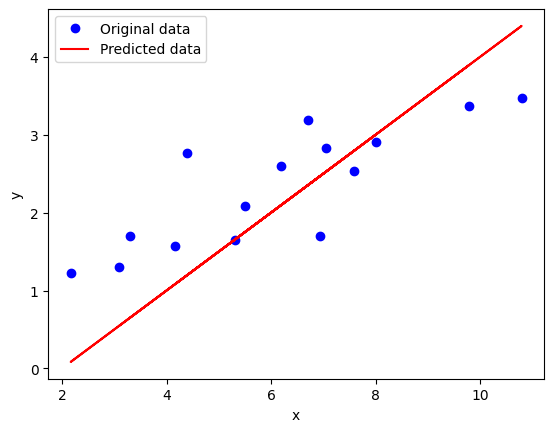

In [49]:
# TO DO:
# - set the weight and bias of the linear model at 0.5 and -1, respectively.
lin_reg_model.weight.data.fill_(0.5)
lin_reg_model.bias.data.fill_(-1)
# - compute the new predictions all_y_pred with this model
all_y_pred = lin_reg_model(all_x)
# - plot the predictions on top of the original data
all_y_pred = all_y_pred.detach()
print(all_y_pred.requires_grad)
plt.figure()
plt.plot(all_x, all_y, 'bo', label='Original data')
plt.plot(all_x, all_y_pred, 'r', label='Predicted data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

### Training

Now that our model is defined, we have to train it, that is, to optimize the values of the weight and bias $w$ and $b$. To do that, we first define the [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and the `optimizer` (i.e., [the optimization algorithm](https://pytorch.org/docs/stable/optim.html#algorithms)).

In [50]:
# TO DO: first, re-instanciate the model and set both the weight and bias at 1.
# This will avoid random values and ensure reproducibility (everyone should get the same results)
input_size = 1
output_size = 1
lin_reg_model = nn.Linear(input_size, output_size, bias=True)
lin_reg_model.weight.data.fill_(1)
lin_reg_model.bias.data.fill_(1)

tensor([1.])

In [51]:
# For linear regression, it is common to use the mean square error (MSE) as loss function
loss_fn = nn.MSELoss()

# For the optimizer, let's use stochastic gradient (SGD). In Pytorch, we need to specify:
# - which parameters are going to be updated (= the model's parameters)
# - the learning rate
optimizer = torch.optim.SGD(lin_reg_model.parameters(), lr=0.01)

Let us briefly recap the gradient descent procedure for training (we note $\mathcal{L}$ the loss function and $\mu$ the learning rate). At each iteration (or *epoch*), we perform the following operations:
1. Using the current model's parameters, compute the predictions: $y_{\text{pred}} = f(x)$
2. Using the loss function, compute the error between true values and predictions: $l = \mathcal{L}(y_{\text{pred}},y)$
3. Compute the gradients of the loss with respect to the parameters. If there are only two parameters $w$ and $b$, then we have to compute $\nabla_{w} l$ and $\nabla_{b} l$.
4. Perform gradient descent, that is, update the parameters with: $w \leftarrow w - \mu \nabla_{w} l$ and $b \leftarrow b - \mu \nabla_{b} l$

The good news is that we don't have to explicitly code steps 3. and 4., since Pytorch takes care about that for us with simple functions: all gradients are computed with `l.backward()` (we have seen this one already) and the gradient descent is simply performed with `optimizer.step()`.

**Note**: before computing the gradients with `l.backward()`, it's safer to remove all possible gradients that have been computed beforehand (e.g., from another model, or stored in the memory) to avoid numerical issues. This is easily done with: `optimizer.zero_grad()`.

In [52]:
# TO DO: Write the training loop for 10 epochs.
# At the end of each epoch, print the value of the loss (it's easily accessed with 'l.item()')
num_epochs = 10
for epoch in range(num_epochs):

    # Forward pass: calculate the predicted value with the model
    y_pred = lin_reg_model(all_x)

    # Compute the error between the true values y and the predicted values
    l = loss_fn(all_y, y_pred)

    # Compute the gradient of the loss with respect to the model parameters
    optimizer.zero_grad()
    l.backward()

    # Apply the gradient descent algorithm
    optimizer.step()

    # Print the loss
    loss_current_epoch = l.item()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))


Epoch [1/10], Loss: 25.6761
Epoch [2/10], Loss: 0.6436
Epoch [3/10], Loss: 0.1803
Epoch [4/10], Loss: 0.1717
Epoch [5/10], Loss: 0.1715
Epoch [6/10], Loss: 0.1715
Epoch [7/10], Loss: 0.1715
Epoch [8/10], Loss: 0.1715
Epoch [9/10], Loss: 0.1715
Epoch [10/10], Loss: 0.1715


In [53]:
# After training, save the parameters of the trained model and display them
torch.save(lin_reg_model.state_dict(), 'model_linear_regression.pt')
print(lin_reg_model.weight)
print(lin_reg_model.bias)

Parameter containing:
tensor([[0.2400]], requires_grad=True)
Parameter containing:
tensor([0.8871], requires_grad=True)


<span style="color:red">**Q2**</span> What are the final values (i.e., after training) of the weight $w$ and bias $b$?

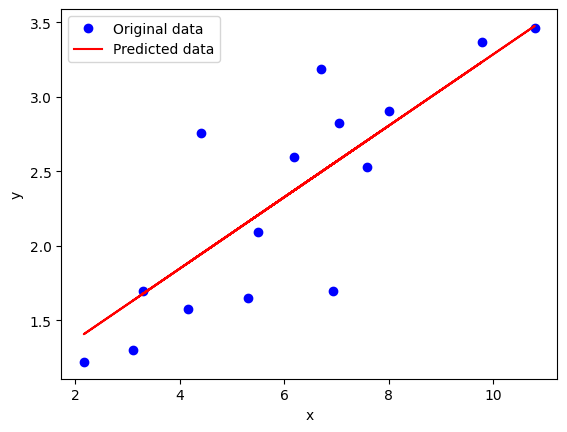

In [54]:
# # TO DO: Compute the final estimates y_pred with the trained model, and display the results (predictions and original)
# y_pred = lin_reg_model(all_x)
y_pred = y_pred.detach()

plt.figure()
plt.plot(all_x, all_y, 'bo', label='Original data')
plt.plot(all_x, y_pred, 'r', label='Predicted data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

Congrats, you have just trained your first model in Pytorch! In practice, this is how easy working with neural networks is, and the training function is always pretty much the same, up to one difference: here he have use the whole dataset (`all_x`) directly, but real-world datasets are much larger, so we need to split it into batches using a `Dataloader` (as we've seen in lab 1), and iterate over these batches (as we will see in lab 3).

Meanwhile, we consider a slightly more complicated model and design our first neural netwotk.

## Nonlinear regression

Let us address the more elaborate task of *nonlinear regression*, where $f$ is no longer a simple linear/affine function.

<center><a href="https://www.r-bloggers.com/2016/02/first-steps-with-non-linear-regression-in-r/">
    <img src="https://i0.wp.com/datascienceplus.com/wp-content/uploads/2016/02/NLS_2.png" width="400"></a></center>

In some scenarios, analyzing/vizualizing the data allows to recognize the nature of $f$ (polynomial, exponential, logarithm...). But sometimes, things get more complicated and even vizualization is not straightforward (e.g., when working with high-dimensional data such as images, audio signals, text data...). That's where neural networks become useful: we only define a general function architecture by assembling elementary operators (linear layers and *activation functions*), which allows to approximate any complicated function (remember the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)).

### Data

For this example, we consider sinusoidal-like data - of course in this case we know the function $f$, but let's pretend we don't and see if we can approximate it using a neural network.

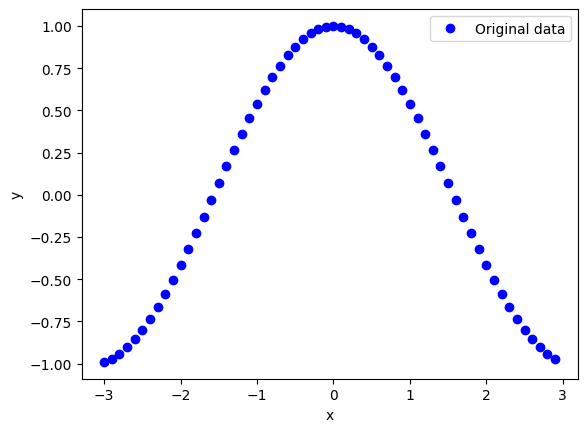

In [55]:
# TO DO: generate sinusoidal data:
# - create a tensor all_x which ranges from -3 to 3 with a step of 0.1
all_x = torch.arange(-3, 3, 0.1)
# - unsqueeze it to add an extra dimension (its shape should be [60, 1])
all_x = all_x.unsqueeze(dim=1)
# - compute all_y = cos(all_x)
all_y = torch.cos(all_x)
# - plot all_y as a function of all_x
plt.figure()
plt.plot(all_x, all_y, 'bo', label='Original data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

### Model

As recalled above, the core idea behind neural networks is to assemble simple mathematical operations to approximate a potentially complicated function. For instance, in multilayer perceptrons (MLP), a network is designed by concatenating several layers, where each layer consists of:
- a linear function
- (potentially) a non-linear element-wise *activation* function

There is a plethora of nonlinear activation functions, which you can check [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). A popular one is the rectified linear unit ([ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)).

Here, we propose to approximate our sinusoidal data with a simple network made up with 2 linear layers and 1 activation function in between:

<center> $x \to$ Linear_1 $\to$ ReLU $\to$ Linear_2 $\to y$</center>


In [56]:
# To DO: write the 'nonlin_reg_model' model.
# - the first linear layer should have input_size=1 and output_size=3 (we increase the dimension of x)
input_size_x = 1
output_size_x = 3
nonlin_reg_model_X = nn.Linear(input_size, output_size, bias=True)
# - the second linear layer should have input_size=3 and output_size=1 (we go back to the dimension of y)
input_size_y = 3
output_size_y = 1
nonlin_reg_model_Y = nn.Linear(input_size, output_size, bias=True)
# - to build the complete model, you can stack the separate layers together into one model using torch.nn.Sequential (check the doc!)
model = nn.Sequential(
    nn.Linear(input_size_x, output_size_x, bias=True),  # Input layer to hidden layer
    nn.ReLU(),  # Activation function
    nn.Linear(input_size_y, output_size, bias=True)  # Hidden layer to output layer
)
# - once it's done, compute nonlin_reg_model(all_x) to be sure there are no bugs
print(model)
nonlin_reg_model = model

Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)


In [57]:
# initialization (ensure reproducibility: everybody should have the same results)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)

torch.manual_seed(0)
nonlin_reg_model.apply(init_weights)

Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)

### Training

In [58]:
# TO DO: train the model. The procedure is very similar to the linear regression case, and uses:
# - loss function = MSE
loss_fn = nn.MSELoss()
# - number of epochs = 50
num_epochs = 50
# - optimizer = SGD with a learning rate of 0.1
optimizer = torch.optim.SGD(nonlin_reg_model.parameters(), lr=0.1)

In [59]:
# TO DO: Plot the loss over epochs
losses = list()

Epoch [1/50], Loss: 0.8169981837272644
Epoch [2/50], Loss: 0.45279064774513245
Epoch [3/50], Loss: 0.3724183440208435
Epoch [4/50], Loss: 0.3247684836387634
Epoch [5/50], Loss: 0.2903457283973694
Epoch [6/50], Loss: 0.2638123333454132
Epoch [7/50], Loss: 0.24239791929721832
Epoch [8/50], Loss: 0.22399969398975372
Epoch [9/50], Loss: 0.2077016681432724
Epoch [10/50], Loss: 0.19311843812465668
Epoch [11/50], Loss: 0.17986874282360077
Epoch [12/50], Loss: 0.16754452884197235
Epoch [13/50], Loss: 0.15600131452083588
Epoch [14/50], Loss: 0.14515921473503113
Epoch [15/50], Loss: 0.13514158129692078
Epoch [16/50], Loss: 0.12570978701114655
Epoch [17/50], Loss: 0.11683384329080582
Epoch [18/50], Loss: 0.10849329829216003
Epoch [19/50], Loss: 0.1006694957613945
Epoch [20/50], Loss: 0.09334351867437363
Epoch [21/50], Loss: 0.08649561554193497
Epoch [22/50], Loss: 0.08010505884885788
Epoch [23/50], Loss: 0.074150450527668
Epoch [24/50], Loss: 0.06860990822315216
Epoch [25/50], Loss: 0.06346540898

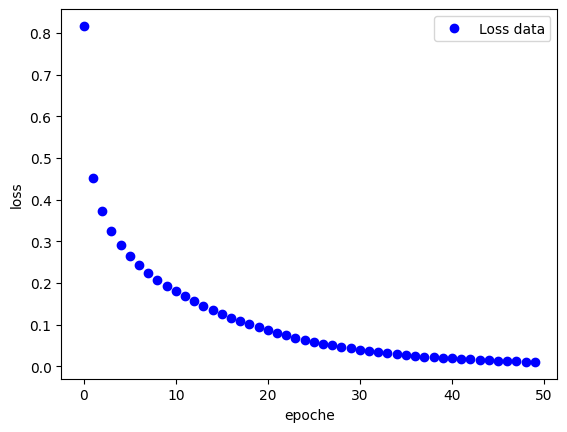

In [60]:
# TO DO: Compute the predicted outputs, and plot the results (original data and predictions)
# Training loop

for epoch in range(num_epochs):
    # Forward pass
    y_pred = nonlin_reg_model(all_x)

    # Calculate loss
    loss = loss_fn(y_pred, all_y)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

    # Save the model's parameters to a file
    torch.save(nonlin_reg_model.state_dict(), 'model_params.pth')
print(len(losses))
num_po = torch.arange(0, len(losses), 1)
plt.figure()
plt.plot(num_po, losses, 'bo', label='Loss data')
plt.xlabel('epoche'), plt.ylabel('loss')
plt.legend()
plt.show()

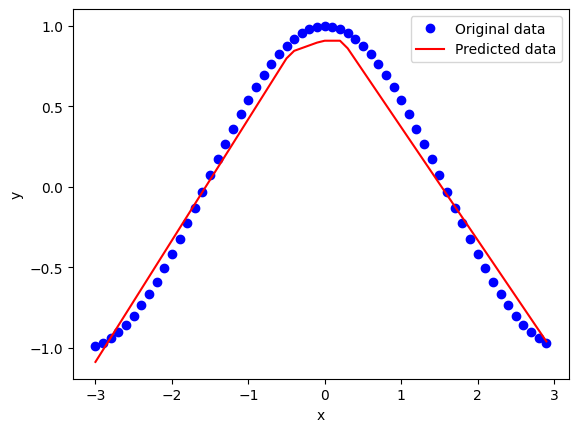

In [61]:
y_pred = y_pred.detach()
plt.figure()
plt.plot(all_x, all_y, 'bo', label='Original data')
plt.plot(all_x, y_pred, 'r', label='Predicted data')
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.show()

<span style="color:red">**Q3 and Q4**</span> Put the above-mentionned plots in your report (loss over epochs and original/predicted data).